# Project Description

## 1. Introduction

## 2. Objectives

### 3.1. Library and Function Definition

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from scipy.stats import norm, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import random

In [2]:
# function definition

# mixing tank simulation
def mixing_tank(mA, mB, mW, xA1, xB2):
    # this fucntion calculate the desired output concentrations os A and B
    # at the outlet stream of a mixing tank
    
    # Inputs
    # - mA: mass flow rate of compound A at inlet stream 1
    # - mB: mass flow rate of compound B at inlet stream 2
    # - mW: mass flow rate of water at inlet stream
    # - xA1: mass fraction of compound A at inlet stream 1
    # - xB2: mass fraction of compound B at inlet strem 2
    
    # Outputs
    # - xA3: mass fraction of compound A at outlet stream
    # - xB3: mass fraction of compound B at outlet stream
    
    total_mass = mA + mB + mW
    xA3 = (xA1*mA)/total_mass
    xB3 = (xB2*mB)/total_mass

    return xA3, xB3

# capability chart construction
def plot_capability_chart(sigma, avg, Pp, Ppk, process_data, LIE, LSE, text):
    # this routine plots the capability chart
    bins = int(1+3.332*np.log10(len(process_data))) # Sturges' rule

    # plot the histogram
    plt.hist(process_data, bins = bins, density=True, alpha = 0.6, color = 'g')

    # plot the PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, avg, sigma)
    plt.plot(x, p, 'k', linewidth = 2)
    title = 'Resultado de Capabilidade - '+text+ ' - Pp = %.2f, Ppk = %.2f'%(Pp, Ppk)
    plt.title(title)
    plt.xlabel(text)
    plt.ylabel('Densidade')
    plt.legend(['Normal Esperada', 'Dados de Processo'], loc = 'upper left')
    plt.axvline(x=LIE)
    plt.axvline(x=LSE)
    plt.text(x = LIE + 0.005*avg, y = 0.20*np.max(p), s = 'LIE')
    plt.text(x = LSE - 0.01*avg, y = 0.20*np.max(p), s = 'LSE')
    
# statistical control chart plot
def plot_control_chart(process_data, text):
    # this subroutine plots the statistical control chart
    x = list(range(len(process_data)-1))
    y = pd.DataFrame(process_data, columns=[text])
    y['moving_range'] = abs(y[text].diff(periods=1))
    y.dropna(inplace=True)

    # constants
    d2 = 1.128
    D3 = 0
    D4 = 3.267

    # moving range control chart
    LC_mr = y['moving_range'].mean()
    LSC_mr = D4*LC_mr
    LIC_mr = D3*LC_mr

    # x values control chart
    LC_x = y[text].mean()
    LSC_x = LC_x + ((3/d2)*LC_mr)
    LIC_x = LC_x - ((3/d2)*LC_mr)

    # control charts plotting
    plt.figure(figsize=(15,20))
    plt.subplot(2,1,1)
    plt.plot(x, y['moving_range'], 'k.-', linewidth=0.5)
    plt.ylabel('Amplitudes Móveis')
    plt.axhline(y = LC_mr)
    plt.axhline(y = LSC_mr)
    plt.axhline(y = LIC_mr)
    plt.title('Cartas de Controle Estatístico - ' + text)
    plt.grid()
    
    plt.subplot(2,1,2)
    plt.plot(x, y[text], 'k.-', linewidth=0.5)
    plt.ylabel(text)
    plt.axhline(y = LC_x)
    plt.axhline(y = LSC_x)
    plt.axhline(y = LIC_x)
    plt.grid()
    plt.show()
    
# capability report analysis
def capability_report(process_data, LIE, LSE, text):
    # this function calculates and plots capability information about the process
    
    np.random.shuffle(process_data)
    
    sigma = np.std(process_data)
    avg = np.mean(process_data)

    Pp = (LSE - LIE)/(6*sigma)

    PPI = (avg - LIE)/(3*sigma)
    PPS = (LSE - avg)/(3*sigma)

    Ppk = np.min([PPI, PPS])

    # plotting capability report
    plt.figure(figsize=(15,10))
    plot_capability_chart(sigma, avg, Pp, Ppk, process_data, LIE, LSE, text)
    plt.show()
    
    plot_control_chart(process_data, text)
    

# correlation scatter plots
def correlation_scatter(data):
    plt.rcParams.update({'font.size': 9})
    plt.figure(figsize=(17,15))
    n = data.shape[1]
    k = 1
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.plot(data[data.columns[i]], data[data.columns[j]], '.k')
            plt.ylabel(data.columns[j])
            plt.xlabel(data.columns[i])
            plt.grid()
            k += 1
    plt.subplots_adjust(wspace=0.6, hspace=0.45)
    plt.show()
    
# theta calculation for SPE confidence limits
def theta_calculation(lambdas, n_components, i, m):
    theta = 0
    for k in range(n_components,m):
        theta += (lambdas[k]**i)
        
    return theta

# SPE confidence limit
def Q_conf_limit(p, eigen, n_comp, n_sensors):
    theta1 = theta_calculation(eigen, n_comp, 1, n_sensors)
    theta2 = theta_calculation(eigen, n_comp, 2, n_sensors)
    theta3 = theta_calculation(eigen, n_comp, 3, n_sensors)
    
    h0 = 1-((2*theta1*theta3)/(3*(theta2**2)))
    
    c_alpha = norm.ppf(p)
    
    limit = theta1*((((c_alpha*np.sqrt(2*theta2*(h0**2)))/theta1)+1+(theta2*h0*(h0-1))/(theta1**2))**(1/h0))
    
    return limit

### 3.2. Case Study - Simulating of a simple Mixing Process

In [3]:
mW = 18520.32
phi1 = 0.2388
phi2 = 0.0031
w1 = 34023.6686
w2 = 113.1535
cond = [0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2]
mA = phi1*mW
mB = phi2*mW
xA1 = mA/w1
xB2 = mB/w2

k = 0.05

# random generations of process measures
N = 10000
mW_vec = np.repeat(np.multiply(cond, mW), N)
mA_vec = phi1*mW_vec
mB_vec = phi2*mW_vec
xA1_vec = mA_vec/w1
xB2_vec = mB_vec/w2

mW_vec += np.random.normal(loc=0, scale = k*np.mean(mW_vec), size = len(mW_vec))
mA_vec += np.random.normal(loc=0, scale = k*np.mean(mA_vec), size = len(mA_vec))
mB_vec += np.random.normal(loc=0, scale = k*np.mean(mB_vec), size = len(mB_vec))
xA1_vec += np.random.normal(loc=0, scale = k*np.mean(xA1_vec), size = len(xA1_vec))
xB2_vec += np.random.normal(loc=0, scale = k*np.mean(xB2_vec), size = len(xB2_vec))

# shuffle conditions before prediction
random.shuffle(mW_vec)
random.shuffle(mA_vec)
random.shuffle(mB_vec)
random.shuffle(xA1_vec)
random.shuffle(xB2_vec)

# mixing tank simulations
xA3_vec, xB3_vec = mixing_tank(mA_vec, mB_vec, mW_vec, xA1_vec, xB2_vec)

# adding noise from sensor
xA3_vec += np.random.normal(loc=0, scale = k*np.mean(xA3_vec), size = len(xA3_vec))
xB3_vec += np.random.normal(loc=0, scale = k*np.mean(xB3_vec), size = len(xB3_vec))

### 3.3. Normal operation data acquisition

In [4]:
# creation of data frame
df = pd.DataFrame({'mA_vec': mA_vec,
                    'mB_vec': mB_vec,
                    'mW_vec': mW_vec,
                    'xA1_vec': xA1_vec,
                    'xB2_vec': xB2_vec,
                    'xA3_vec': xA3_vec,
                    'xB3_vec': xB3_vec},
                    index=list(range(len(mA_vec))))
columns=['mA',
                    'mB',
                    'mW',
                    'xA1',
                    'xB2',
                    'xA3',
                    'xB3']
df.columns = columns

df.head()
df.describe()

,mA,mB,mW,xA1,xB2,xA3,xB3
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,4422.693601,57.406146,18523.607610,0.130024,0.507393,0.025214,0.001282
std,585.138717,7.585387,2449.772757,0.017183,0.067112,0.005263,0.000288
min,2720.384163,33.251421,11558.403582,0.080930,0.311738,0.009493,0.000409
25%,4004.462747,52.001152,16782.379534,0.117781,0.459815,0.021436,0.001075
50%,4421.410294,57.404783,18520.345347,0.130060,0.507495,0.024828,0.001259
75%,4841.163812,62.804139,20256.978043,0.142340,0.555349,0.028602,0.001464
max,6133.461997,81.402498,25690.768180,0.178809,0.707544,0.049623,0.002781


#### 3.3.1. Data Visualization

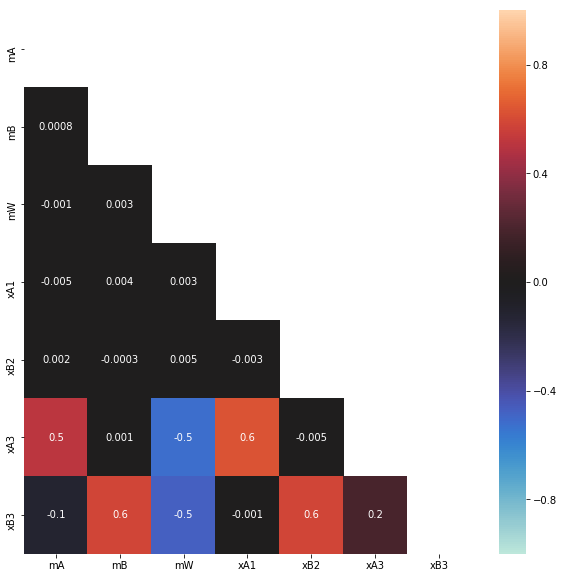

In [5]:
# calcutating Pearson correlation matrix
matrix = np.triu(df.corr())
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, mask=matrix, fmt='.1g', vmin = -1, vmax = 1, center = 0)

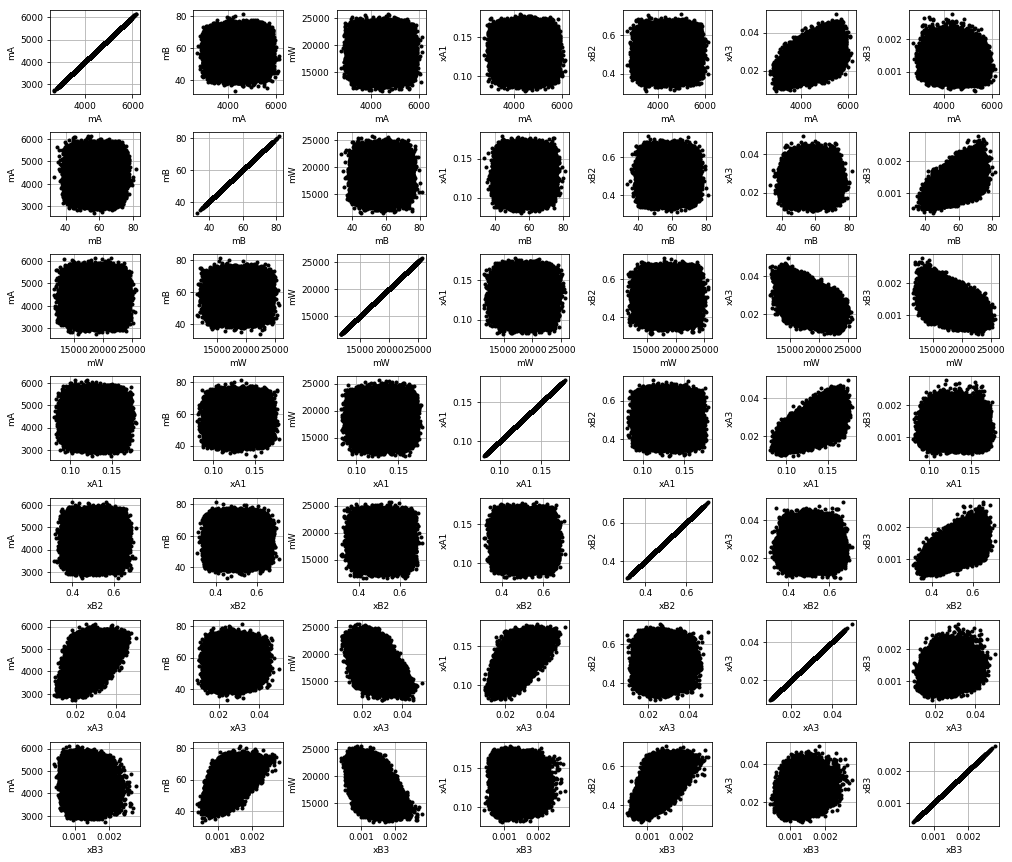

In [6]:
# correlation scatter plots
correlation_scatter(df)

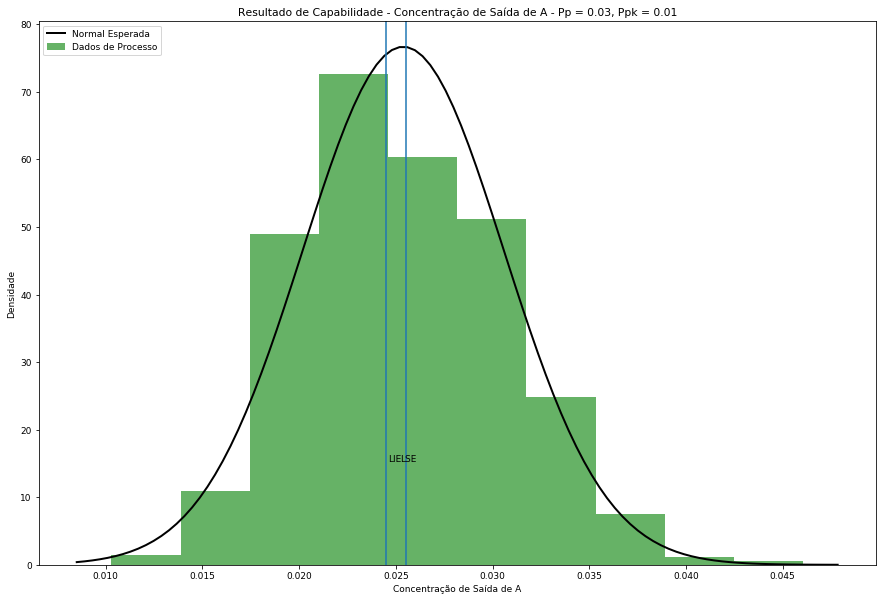

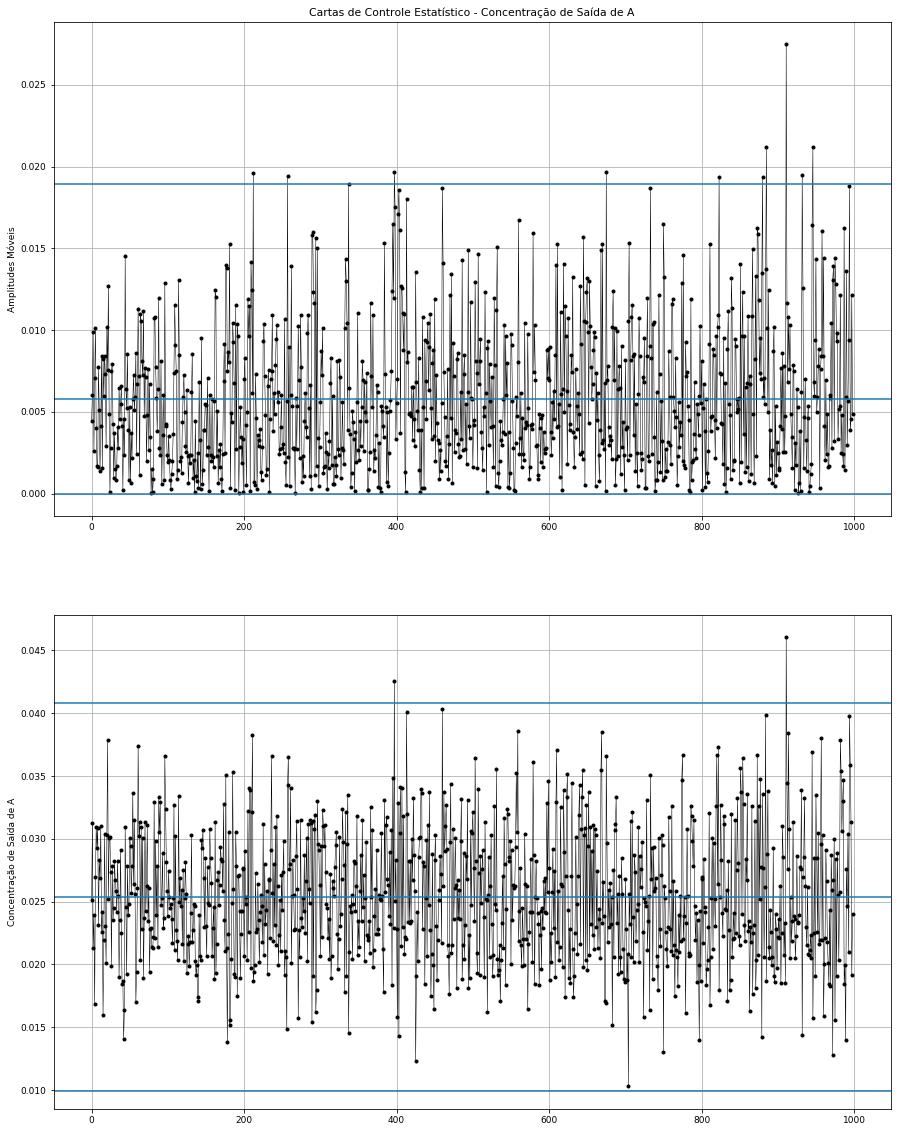

In [7]:
lse_A = 0.0255
lie_A = 0.0245
capability_report(np.random.choice(xA3_vec,1000), lie_A, lse_A, 'Concentração de Saída de A')

In [8]:
# before proceeding to PCA application, let's select only data points that corresponds to points within specifications
# A fraction must be within 2.45 % - 2.55 %
# B fraction must be within 0.1 % - 0.2 %

lse_B = 0.001
lie_B = 0.002

print('Original Dataset Size: ', df.shape)

normal_df = df.loc[(df['xA3'] >= lie_A) & (df['xA3'] <= lse_A)].copy()

print('Selected Dataset Size: ', normal_df.shape)

Original Dataset Size:  (70000, 7)
Selected Dataset Size:  (5267, 7)


### 3.4. PCA Algorithm Training

#### 3.4.1. Feature Scaling

In [9]:
# feature scaling is necessary because PCA algorithms are biased due feature distinct scales
scaler = StandardScaler()

x_sc = scaler.fit_transform(normal_df)
print(x_sc)

[[ 0.20746881 -1.20322071 -0.90210502 ... -0.67311712  0.43304942
  -1.00720003]
 [ 0.17589639 -0.77102554 -0.4018137  ... -0.51754583 -1.12121524
  -0.59988426]
 [-0.12593987 -1.44338247  2.1284899  ... -0.91008008 -1.35692866
  -1.86714185]
 ...
 [-0.96885143 -1.5728121  -1.52095894 ... -1.41074005  1.3130522
  -0.93652194]
 [ 0.7873318   0.59673722  0.47714534 ... -0.34166896 -1.36731978
  -0.5418838 ]
 [ 1.10707391 -0.13317671 -0.23987203 ... -1.00936317  1.27027669
  -0.66964431]]


#### 3.4.2. PCA  Application

##### 3.4.2.1. Parallel Analysis Method

In [10]:
# let's verify how much components we must retain (parallel analysis method)
pca = PCA(n_components=len(x_sc[0]))
model = pca.fit_transform(x_sc)
corr_eigen = pca.explained_variance_
print(corr_eigen)

[2.11651288 1.52640133 1.24352541 1.00877162 0.98226357 0.08794532
 0.03590915]


In [11]:
# generation of uncorrelated dataset using mean and standard deviation of original variables
mA_unc = np.random.normal(loc = df[df.columns[0]].mean(), scale = df[df.columns[0]].std(), size = df.shape[0])
mB_unc = np.random.normal(loc = df[df.columns[1]].mean(), scale = df[df.columns[1]].std(), size = df.shape[0])
mW_unc = np.random.normal(loc = df[df.columns[2]].mean(), scale = df[df.columns[2]].std(), size = df.shape[0])
xA1_unc = np.random.normal(loc = df[df.columns[3]].mean(), scale = df[df.columns[3]].std(), size = df.shape[0])
xB2_unc = np.random.normal(loc = df[df.columns[4]].mean(), scale = df[df.columns[4]].std(), size = df.shape[0])
xA3_unc = np.random.normal(loc = df[df.columns[5]].mean(), scale = df[df.columns[5]].std(), size = df.shape[0])
pH_unc = np.random.normal(loc = df[df.columns[6]].mean(), scale = df[df.columns[6]].std(), size = df.shape[0])

df_unc = pd.DataFrame({'mA_unc': mA_unc,
                    'mB_unc': mB_unc,
                    'mW_unc': mW_unc,
                    'xA1_unc': xA1_unc,
                    'xB2_unc': xB2_unc,
                    'xA3_unc': xA3_unc,
                    'pH_unc': pH_unc},
                    index=list(range(len(mA_unc))))

df_unc.head()

,mA_unc,mB_unc,mW_unc,xA1_unc,xB2_unc,xA3_unc,pH_unc
0,4958.123873,53.396597,20562.759649,0.140235,0.394178,0.019378,0.000859
1,4563.185070,45.087334,18184.513035,0.123395,0.564326,0.018047,0.001675
2,4584.248440,50.652425,14500.602578,0.125548,0.577925,0.020893,0.001344
3,4465.390794,59.782660,16242.128963,0.104883,0.568083,0.022115,0.001099
4,3495.543561,57.257715,17026.151204,0.111156,0.485461,0.022853,0.001064


In [12]:
# feature scaling of uncorrelated dataset
x_unc = scaler.fit_transform(df_unc)

# pca application
pca_unc = PCA(n_components = df_unc.shape[1])
model_unc = pca_unc.fit_transform(x_unc)
unc_eigen = pca_unc.explained_variance_
print(unc_eigen)

[1.01374103 1.01132902 1.00145759 0.99976397 0.99496528 0.99365087
 0.98519224]


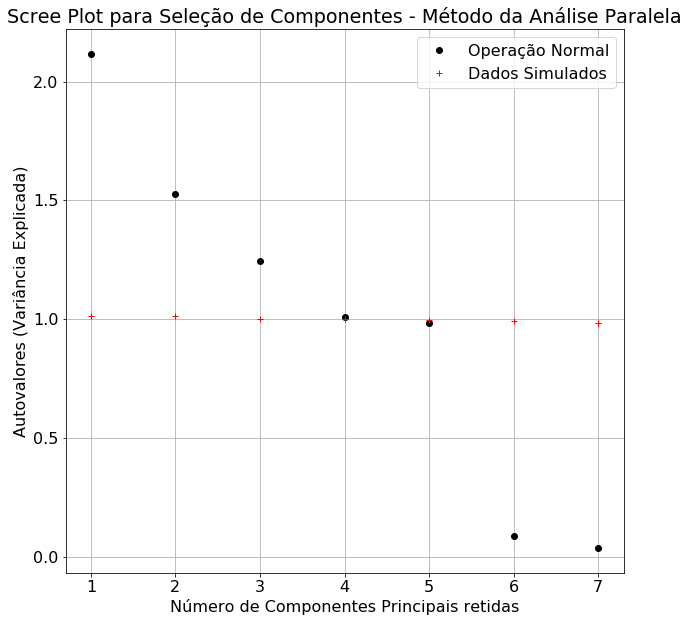

In [13]:
# let's visualize scree plots of both pca results
x = list(range(len(corr_eigen)))
x = [i+1 for i in x]
         
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
plt.plot(x, corr_eigen, 'ko')
plt.plot(x, unc_eigen, 'r+')
plt.ylabel('Autovalores (Variância Explicada)')
plt.xlabel('Número de Componentes Principais retidas')
plt.legend(['Operação Normal', 'Dados Simulados'], loc = 'upper right')
plt.title('Scree Plot para Seleção de Componentes - Método da Análise Paralela')
plt.grid()
plt.show()

##### 3.4.2.2. PCA Algorithm Training using Normal Operation Dataset

In [14]:
finalPCA = PCA(n_components = 4)
model_final = finalPCA.fit_transform(x_sc)
finalPCA.explained_variance_ratio_.sum()

0.8420131384503433

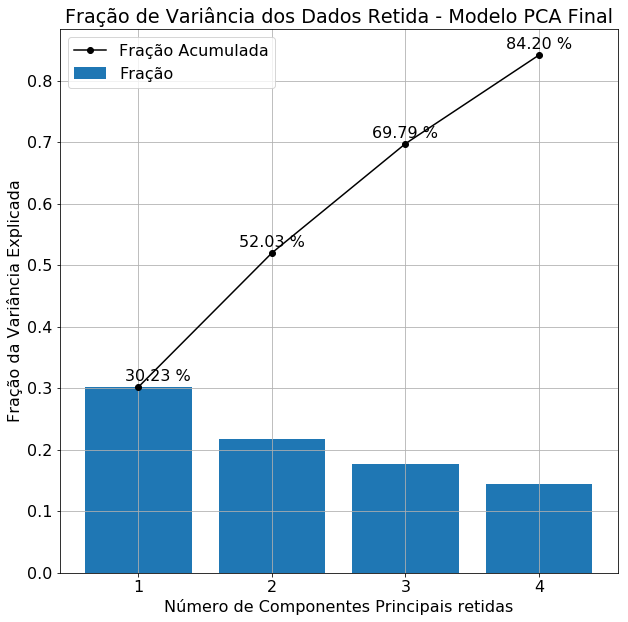

In [15]:
frac_cum = []
frac_cum.append(finalPCA.explained_variance_ratio_[0])

for i in range(1, len(finalPCA.explained_variance_ratio_)):
    frac_cum.append(frac_cum[i-1]+finalPCA.explained_variance_ratio_[i])
    
x = list(range(len(frac_cum)))
x = [i+1 for i in x]

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
plt.bar(x, finalPCA.explained_variance_ratio_[0:])
plt.plot(x, frac_cum, 'ko-')
plt.ylabel('Fração da Variância Explicada')
plt.xlabel('Número de Componentes Principais retidas')
plt.xticks(ticks=x)
plt.text(x = x[0]-0.1, y = frac_cum[0] + 0.01, s = '{:.2f} %'.format(frac_cum[0]*100))
plt.text(x = x[1]-0.25, y = frac_cum[1] + 0.01, s = '{:.2f} %'.format(frac_cum[1]*100))
plt.text(x = x[2]-0.25, y = frac_cum[2] + 0.01, s = '{:.2f} %'.format(frac_cum[2]*100))
plt.text(x = x[3]-0.25, y = frac_cum[3] + 0.01, s = '{:.2f} %'.format(frac_cum[3]*100))
plt.legend(['Fração Acumulada', 'Fração'], loc = 'upper left')
plt.title('Fração de Variância dos Dados Retida - Modelo PCA Final')
plt.grid()
plt.show()

##### 3.4.2.3. Calculation of Hotelling's T² statistic and its superior confidence limit

In [16]:
# calculation of Hotelling T² statistics
P = finalPCA.components_.T
lambdas = finalPCA.explained_variance_

hotellings_t2s = np.array([xi.dot(P)
                            .dot(np.diag(lambdas**-1))
                            .dot(P.T).dot(xi.T)
                                 for xi in x_sc])
print(hotellings_t2s)

[3.67501812 1.80136659 9.69022133 ... 7.78803885 1.46575068 3.54454876]


In [17]:
# calculate the maximum allowable T²
conf = 0.99
l = len(finalPCA.components_)
maxT2 = chi2.ppf(0.99, l)
print('Maximum Confident Limit for T²: {:.2f} ({:.2f} % confidence)'.format(maxT2, conf*100)) 

Maximum Confident Limit for T²: 13.28 (99.00 % confidence)


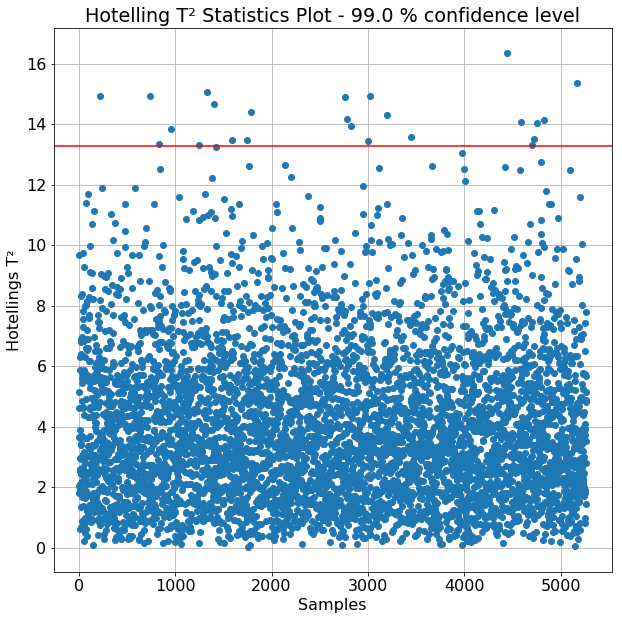

In [18]:
# plot the observed hottelings T2
plt.figure(figsize=(10,10))
plt.plot(range(len(hotellings_t2s)), hotellings_t2s, 'o')
plt.axhline(y = maxT2, color='red')
plt.xlabel('Samples')
plt.ylabel('Hotellings T²')
plt.title('Hotelling T² Statistics Plot - {} % confidence level'.format(conf*100))
plt.grid()
plt.show()

Hotelling's T² statistic represent the squared length of the projection of the current sample into the space spanned by PCA model. It is an indication of how far the PCA estimate of the sample is from multivariate mean of the data, i.e, the intersection of the principal component.

- if a sample has an abnormal value of T² but Q value below the limit, it is not necessarly a fault - it can also be a change of the operating region

##### 3.4.2.4. Calculation of SPE (Square Prediction Error) and its superior confidence limit

In [19]:
r = x_sc.dot(np.identity(P.shape[0])-P.dot(P.T))
Q = []
for i in range(r.shape[0]):
    Q.append(r[i].dot(r[i].T))

In [20]:
# calculate the confidence limit of SPE
Qmax = Q_conf_limit(conf, corr_eigen, len(lambdas), df.shape[1])
print('Maximum Confident Limit for SPE: {:.2f} ({:.2f} % confidence)'.format(Qmax, conf*100))

Maximum Confident Limit for SPE: 6.89 (99.00 % confidence)


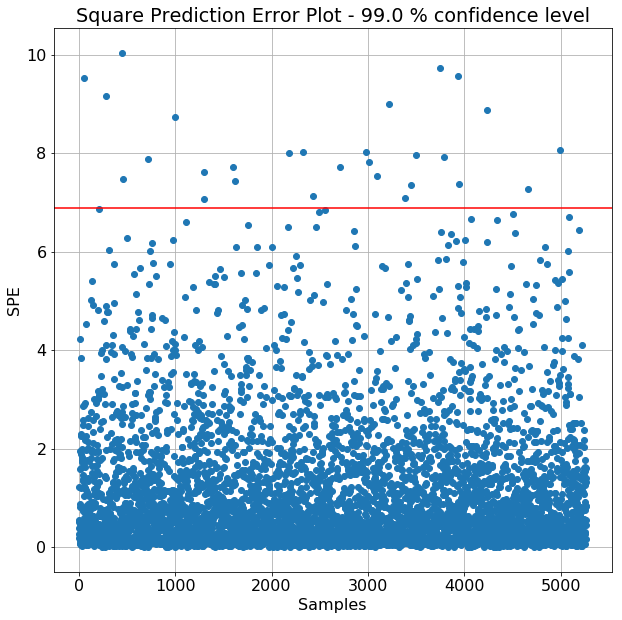

In [21]:
# plot the observed SPE
plt.figure(figsize=(10,10))
plt.plot(range(len(Q)), Q, 'o')
plt.axhline(y = Qmax, color='red')
plt.xlabel('Samples')
plt.ylabel('SPE')
plt.title('Square Prediction Error Plot - {} % confidence level'.format(conf*100))
plt.grid()
plt.show()

The Q statistic shows how well a new sample fits into the PCA model built on previous measurement data. It is a measure of the distance (residual) between the sample and its projection ont the l principal components retained in the model.

- if a sample shows both abnormal T² and Q values, then it is very possible to represent a process anomaly.

##### 3.4.2.5. Contribution Plots

In [22]:
normal_df['T²'] = hotellings_t2s
normal_df['Q'] = Q
normal_df.head()

,mA,mB,mW,xA1,xB2,xA3,xB3,T²,Q
10,4562.422596,48.301528,16649.630384,0.113454,0.463256,0.025123,0.000989,3.675018,0.274217
32,4545.965479,51.588591,17752.292128,0.136112,0.473640,0.024679,0.001105,1.801367,0.543458
37,4388.633367,46.474976,23329.180809,0.160436,0.447439,0.024611,0.000745,9.690221,0.177216
71,5105.481719,64.204962,21745.972732,0.134345,0.408439,0.025233,0.000946,5.155947,1.228784
78,4450.626246,62.763005,19119.654810,0.138119,0.542628,0.024647,0.001451,2.054475,0.504314


In [23]:
# construct dataframe with individual prediction error
sqe_i = pd.DataFrame(r**2)

name_list =[]
for i in range(sqe_i.shape[1]):
    name_list.append('Sensor_'+df.columns[i])
    
    
sqe_i.columns = name_list
sqe_i.head()

,Sensor_mA,Sensor_mB,Sensor_mW,Sensor_xA1,Sensor_xB2,Sensor_xA3,Sensor_xB3
0,0.013272,0.044386,0.001319,0.005611,0.140453,0.049350,0.019826
1,0.148130,0.022414,0.118848,0.153485,0.059345,0.035663,0.005572
2,0.023689,0.009042,0.000052,0.016504,0.052887,0.004001,0.071042
3,0.000489,0.505004,0.000408,0.003284,0.466798,0.252784,0.000017
4,0.028904,0.162621,0.025770,0.018921,0.169480,0.098409,0.000209


In [24]:
# reset index
normal_df.reset_index(inplace=True)
# normal_df.head()

# joining tables
frame = [normal_df, sqe_i]
final_df = pd.concat(frame, axis = 1)
final_df.head()

,index,mA,mB,mW,xA1,xB2,xA3,xB3,T²,Q,Sensor_mA,Sensor_mB,Sensor_mW,Sensor_xA1,Sensor_xB2,Sensor_xA3,Sensor_xB3
0,10,4562.422596,48.301528,16649.630384,0.113454,0.463256,0.025123,0.000989,3.675018,0.274217,0.013272,0.044386,0.001319,0.005611,0.140453,0.049350,0.019826
1,32,4545.965479,51.588591,17752.292128,0.136112,0.473640,0.024679,0.001105,1.801367,0.543458,0.148130,0.022414,0.118848,0.153485,0.059345,0.035663,0.005572
2,37,4388.633367,46.474976,23329.180809,0.160436,0.447439,0.024611,0.000745,9.690221,0.177216,0.023689,0.009042,0.000052,0.016504,0.052887,0.004001,0.071042
3,71,5105.481719,64.204962,21745.972732,0.134345,0.408439,0.025233,0.000946,5.155947,1.228784,0.000489,0.505004,0.000408,0.003284,0.466798,0.252784,0.000017
4,78,4450.626246,62.763005,19119.654810,0.138119,0.542628,0.024647,0.001451,2.054475,0.504314,0.028904,0.162621,0.025770,0.018921,0.169480,0.098409,0.000209


In [25]:
# select data with prediction error above confidence limit
name_list += 'Q'
anomaly_train = final_df.loc[final_df['Q']>Qmax, name_list]
anomaly_train.sort_values(by='Q', ascending=False)
anomaly_train.head()

,Sensor_mA,Sensor_mB,Sensor_mW,Sensor_xA1,Sensor_xB2,Sensor_xA3,Sensor_xB3,Q
57,0.000882,3.987489,0.001555,0.036630,3.557412,1.951711,0.001523,9.537202
286,0.163903,3.397603,0.198381,0.447595,3.352582,1.600629,0.002351,9.163044
448,0.237443,3.436251,0.148888,0.083353,4.021694,2.082822,0.028007,10.038458
458,0.000107,2.939932,0.000899,0.039230,2.970431,1.521194,0.002909,7.474701
721,0.040650,3.613815,0.009725,0.161532,2.514400,1.509003,0.043333,7.892459


28 anomalies detected


ValueError: num must be 1 <= num <= 6, not 7

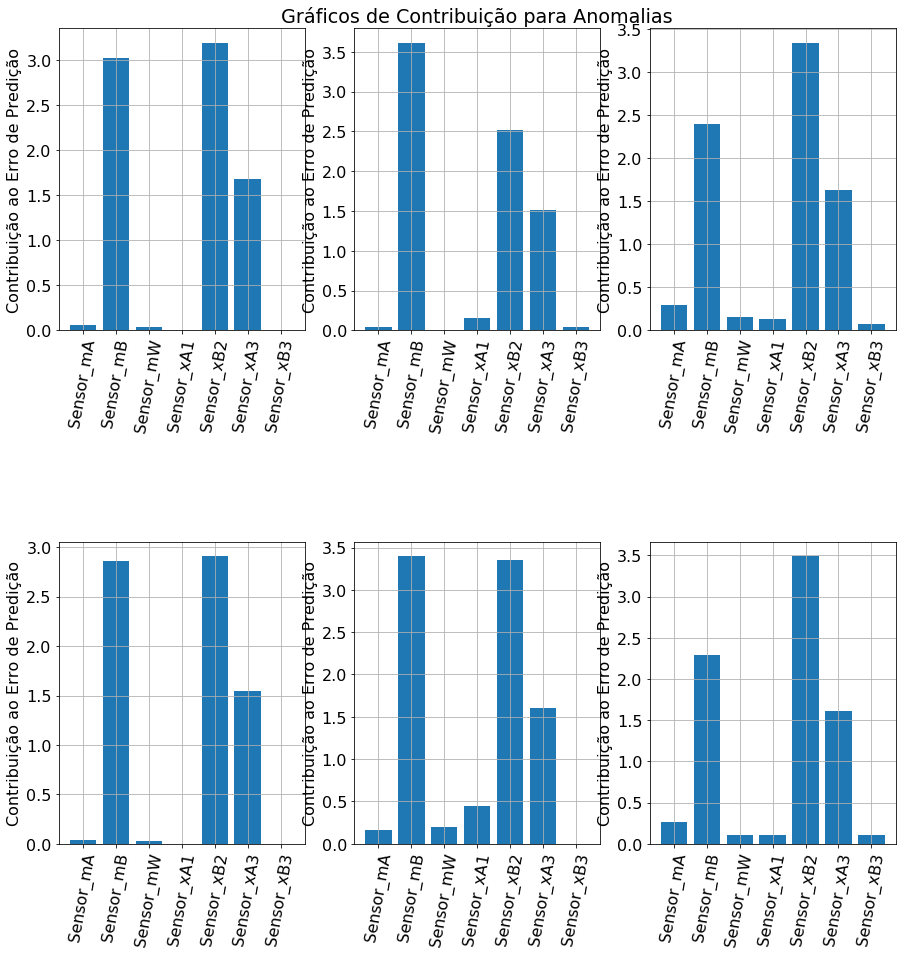

In [26]:
# Number of Anomalies Detected
print('{} anomalies detected'.format(anomaly_train.shape[0]))

# plot some contributions plot
samples = np.array(anomaly_train.sample(anomaly_train.shape[0]).index)

col_names = anomaly_train.columns.drop('Q')
x = np.arange(len(col_names))

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
for i in range(len(samples)):
    plt.subplot(2,3,i+1)
    plt.grid()
    plt.bar(x, anomaly_train.loc[samples[i], col_names], label = col_names[i])
    plt.ylabel('Contribuição ao Erro de Predição')
    plt.xticks(x, col_names, rotation = 80)
    
    if i == 1:
        plt.title('Gráficos de Contribuição para Anomalias')

plt.show()

##### 3.4.2.6. Highlighting anomalies

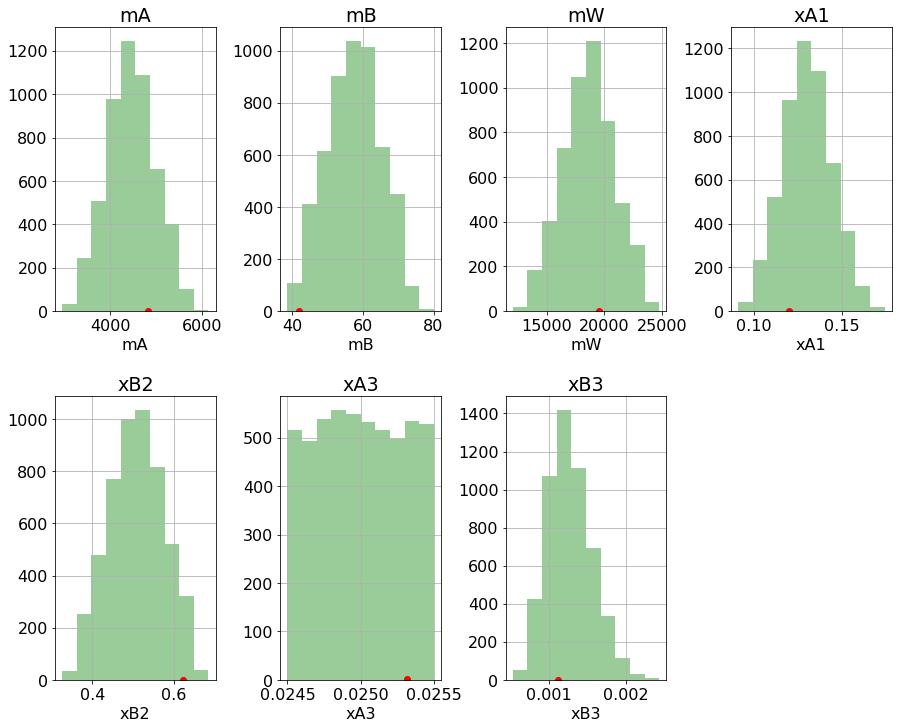

In [27]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
for i in range(1,8):
    plt.subplot(2,4,i)
    plt.grid()
    plt.hist(final_df[final_df.columns[i]], alpha=0.4, color = 'g')
    plt.plot(final_df.loc[samples[0], final_df.columns[i]], 1, 'or')
    plt.xlabel(final_df.columns[i])
    plt.title(final_df.columns[i])

plt.show()

### 3.5. Anomaly Detection

In [28]:
# selecting "out of specification" data
anomaly_data = df.loc[(df['xA3'] < lie_A) | (df['xA3'] > lse_A)].copy()

print('Original Dataset Size: ', df.shape)
print('Normal Operation Dataset Size: ', normal_df.shape)
print('Potential Anomaly Dataset Size: ', anomaly_data.shape)

Original Dataset Size:  (70000, 7)
Normal Operation Dataset Size:  (5267, 10)
Potential Anomaly Dataset Size:  (64733, 7)


In [29]:
# feature scaling
x_anom = scaler.fit_transform(anomaly_data)

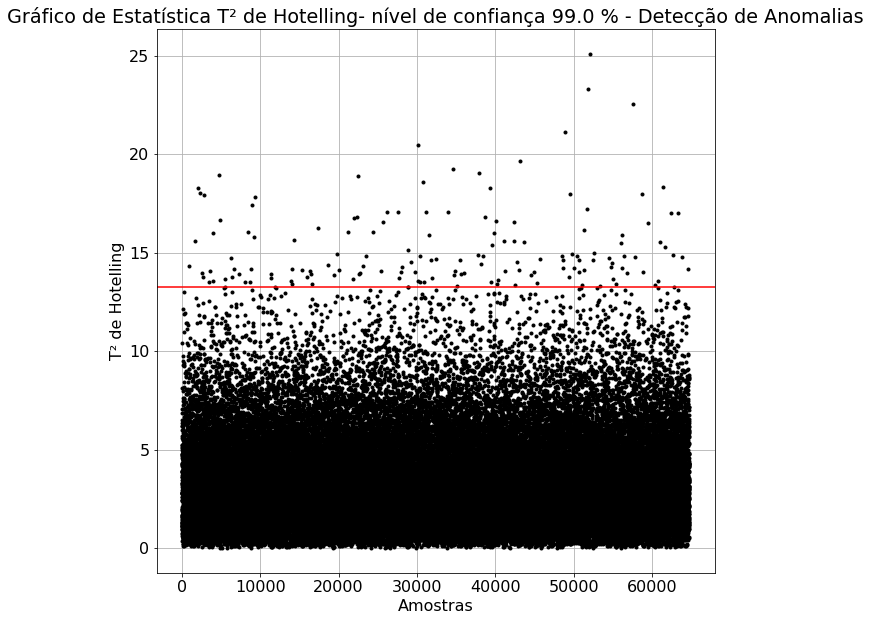

In [30]:
# application of trained PCA and Hotellings T² calculation
hotellings_t2s_anom = np.array([xi.dot(P)
                            .dot(np.diag(lambdas**-1))
                            .dot(P.T).dot(xi.T)
                                 for xi in x_anom])

plt.figure(figsize=(10,10))
plt.plot(range(len(hotellings_t2s_anom)), hotellings_t2s_anom, '.k')
plt.axhline(y = maxT2, color='red')
plt.xlabel('Amostras')
plt.ylabel('T² de Hotelling')
plt.title('Gráfico de Estatística T² de Hotelling- nível de confiança {} % - Detecção de Anomalias'.format(conf*100))
plt.grid()
plt.show()

In [45]:
print((hotellings_t2s_anom > maxT2).sum()*100/len(hotellings_t2s_anom))

0.2332658767552871


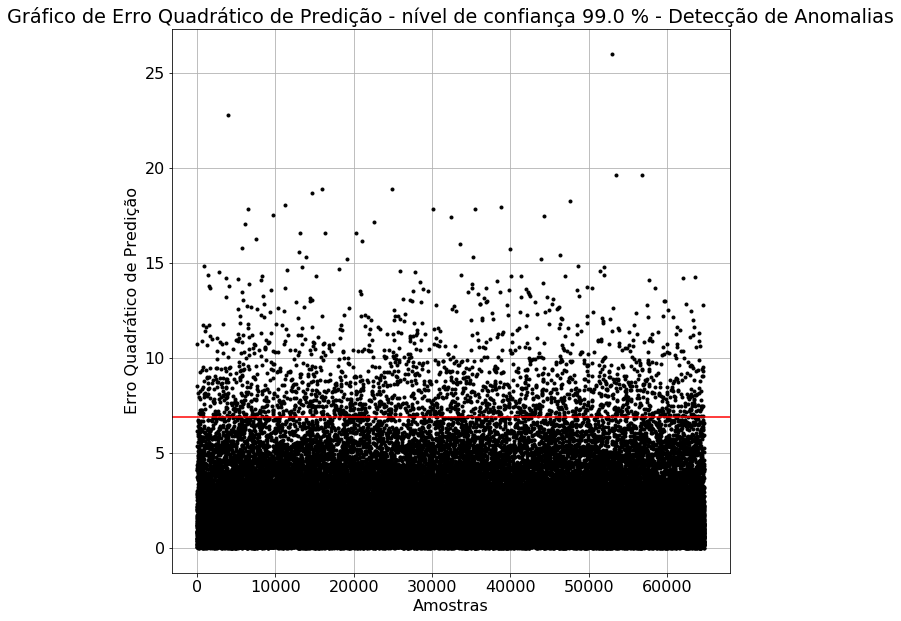

In [31]:
r = x_anom.dot(np.identity(P.shape[0])-P.dot(P.T))
Q = []
for i in range(r.shape[0]):
    Q.append(r[i].dot(r[i].T))

plt.figure(figsize=(10,10))
plt.plot(range(len(Q)), Q, 'k.')
plt.axhline(y = Qmax, color='red')
plt.xlabel('Amostras')
plt.ylabel('Erro Quadrático de Predição')
plt.title('Gráfico de Erro Quadrático de Predição - nível de confiança {} % - Detecção de Anomalias'.format(conf*100))
plt.grid()
plt.show()

In [46]:
print((Q > Qmax).sum()*100/len(Q))

3.0911590687902617


In [32]:
# lets select only those points that have both Q and T² out of bounds
anomaly_data['T²'] = hotellings_t2s_anom
anomaly_data['Q'] = Q

sqe_i = pd.DataFrame(r**2)

name_list =[]
for i in range(sqe_i.shape[1]):
    name_list.append('Sensor_'+df.columns[i])
    
sqe_i.columns = name_list

# reset index
anomaly_data.reset_index(inplace=True)

# joining tables
frame = [anomaly_data, sqe_i]
anomaly = pd.concat(frame, axis = 1)

# select data with prediction error above confidence limit
name_list += 'Q'
anomaly_true = anomaly.loc[(anomaly['Q']>Qmax) & (anomaly['T²']>maxT2), name_list]

# Number of Anomalies Detected
print('{} anomalies detected'.format(anomaly_true.shape[0]))

44 anomalies detected


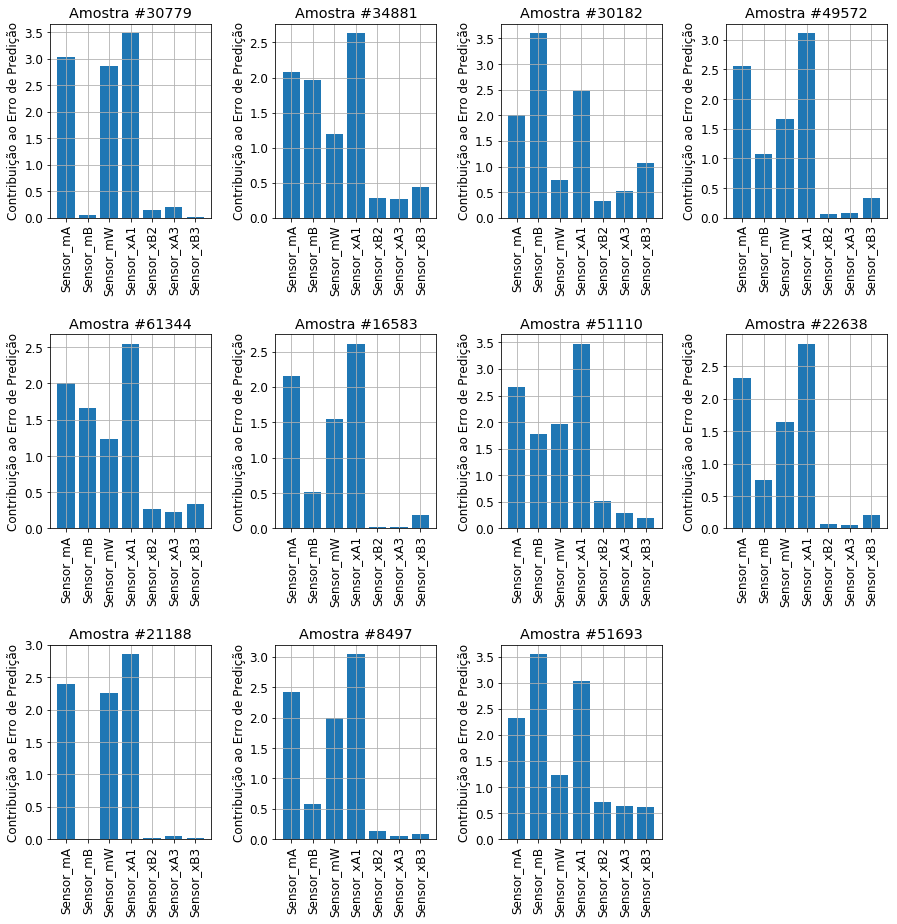

In [49]:
# plot some contributions plot
n = 12
samples = np.array(anomaly_true.sample(n).index)
plt.rcParams.update({'font.size': 12})

col_names = anomaly_true.columns.drop('Q')
x = np.arange(len(col_names))

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace = 0.4, hspace = 0.6)
for i in range(1,len(samples)):
    plt.subplot(3,4,i)
    plt.grid()
    plt.bar(x, anomaly_true.loc[samples[i], col_names])
    plt.ylabel('Contribuição ao Erro de Predição')
    plt.xticks(x, col_names, rotation = 90)
    plt.title('Amostra #'+ str(samples[i]))

plt.show()

In [84]:
sqe_i_anom = sqe_i.loc[sqe_i.sum(axis=1) > Qmax]
SQE_par = pd.DataFrame(sqe_i_anom.idxmax(axis=1).value_counts()/len(sqe_i_anom.idxmax(axis=1)))
SQE_par.columns = ['Frequência Relativa']
SQE_par.head()

,Frequência Relativa
Sensor_mB,0.594203
Sensor_xA1,0.339830
Sensor_xB2,0.065467
Sensor_mA,0.000500


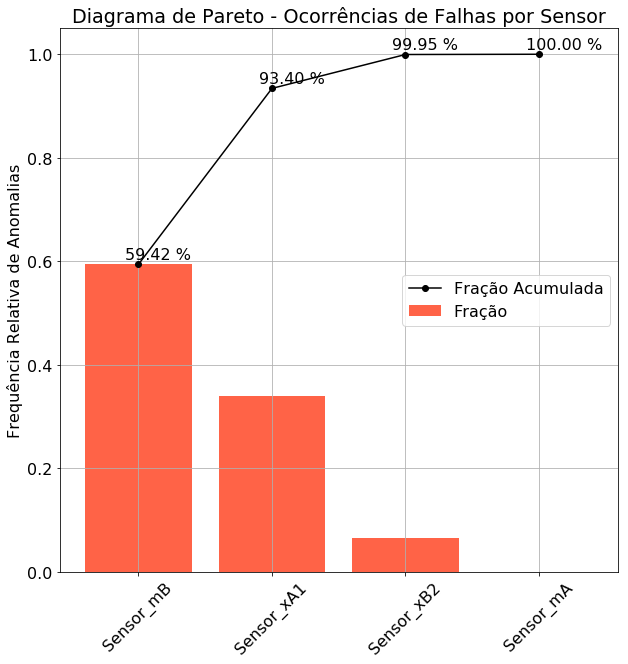

In [87]:
frac_cum = []
frac_cum.append(SQE_par['Frequência Relativa'][0])

for i in range(1, len(SQE_par['Frequência Relativa'])):
    frac_cum.append(frac_cum[i-1]+SQE_par['Frequência Relativa'][i])
    
x = list(range(len(frac_cum)))
x = [i+1 for i in x]

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
plt.bar(x, SQE_par['Frequência Relativa'], color = 'tomato')
plt.plot(x, frac_cum, 'ko-')
plt.ylabel('Frequência Relativa de Anomalias')
plt.xticks(ticks=x, labels = SQE_par.index, rotation = 45)
for i in range(len(SQE_par['Frequência Relativa'])):
    plt.text(x = x[i]-0.1, y = frac_cum[i] + 0.01, s = '{:.2f} %'.format(frac_cum[i]*100))
plt.legend(['Fração Acumulada', 'Fração'], loc = 'center right')
plt.title('Diagrama de Pareto - Ocorrências de Falhas por Sensor')
plt.grid()
plt.show()

In [89]:
samples

array([60980, 30779, 34881, 30182, 49572, 61344, 16583, 51110, 22638,
       21188,  8497, 51693], dtype=int64)

In [103]:
anomaly.iloc[30779]

index         33295.000000
mA             5829.653498
mB               70.896412
mW            14418.866248
xA1               0.160636
xB2               0.401210
xA3               0.043698
xB3               0.001342
T²               18.584778
Q                 9.816613
Sensor_mA         3.027428
Sensor_mB         0.058915
Sensor_mW         2.873277
Sensor_xA1        3.491253
Sensor_xB2        0.155128
Sensor_xA3        0.201284
Sensor_xB3        0.009329
Name: 30779, dtype: float64

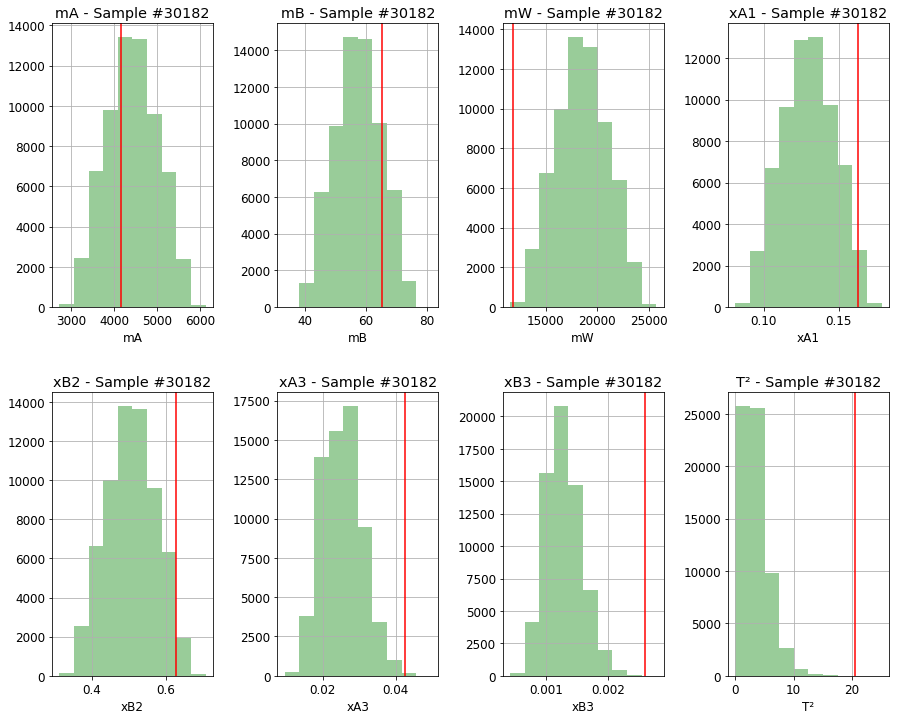

In [91]:
# Highlighting anomaly
plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
for i in range(2,10):
    plt.subplot(2,4,i-1)
    plt.grid()
    plt.hist(anomaly[anomaly.columns[i-1]], alpha=0.4, color = 'g')
    plt.axvline(x = anomaly.loc[samples[3], anomaly.columns[i-1]], color = 'r')
    plt.xlabel(anomaly.columns[i-1])
    plt.title(anomaly.columns[i-1] + ' - Sample #' + str(samples[3]))

plt.show()